### Development notes

Define _messiness_ as variations in data types or completeness.
Define _noise_ as outliers.

1. Create noise arguments in add_arrays:
    * Research best method. Probably overlaying (by addition or multiplication) another random distribution.
    * What argument to accept? Float between 0 and 1, where 0 is no noise, and 1 makes the array completely random?
2. Create messiness:
    * Apply messiness arguments to each feature after generating the dataframe.
    * Let user specify percent of data that would be NaN.
    * Let user specify percent of data that's incorrect type. (e.g., value = str(numerical_value); float_value = int(float_value))
    * Let user specify percent of outliers.
3. Downcasting in _make_arrays:
    * Allow arrays to have other numerical data types. E.g., what if the distributions yield integers?


### Currently working on ...

**Runtime optimization**
* Analyze operation run times.


In [1]:
import pandas
import numpy

import seaborn
import matplotlib.pyplot as plt

%matplotlib inline


#DEBUGGING
from pprint import pprint
from time import time
# import line_profiler
# %load_ext line_profiler


In [2]:
class Pseudodata:
    """
    Anticipated workflow
    1. Create Pseudodata instance.
    2. Add two or more distribution arrays.
    3. Generate an output pseudodata DataFrame from the distribution arrays.
    4. Add an additional array to the dataset. Give option to update the pseudodata DataFrame automatically or manually (with method).
    5. Output the pseudodata DataFrame as Pandas object. OPTIONAL OTHER FORMATS?
    6. VISUALIZE THE DATAFRAME?
    
    Development plan
    * Add 'messiness' arguments
    * Allow non-numerical data arrays; i.e., text. (MAP STRING VALUES TO NUMBERS, THEN SUBSTITUTE BACK AFTER MAKING DATAFRAME?)
    """
    reduced_memory = bool
    data_profile = dict()
    features_data = dict()
    dataframe = pandas.DataFrame()
    
    def __init__(self, conserve_memory=False):
        """Downcast datatypes to reduce memory allocations."""
        self.reduced_memory = conserve_memory
        self.data_profile = dict()
        self.features_data = dict()
        self.dataframe = pandas.DataFrame()
        self._check_setup()
    
    def _check_setup(self):
        try:
            modules
        except:
            from sys import modules
        for module in ['pandas', 'numpy']:
            if module not in modules:
                print("{} not imported".format(module))

    def get_profile(self):
        """Displays a description of the arrays in the Pseudodata instance as a DataFrame object."""
        return pandas.DataFrame(self.data_profile).T

    def list_available_distributions(self, detailed_list=False):
        """Returns a list of the univariate distributions available in numpy.random."""
        rand_docstring = numpy.random.__doc__
        prefiltered_doc_string = rand_docstring.split('variate distributions')[1].split('\n')
        dist_filter = filter(lambda x: 'distribution' in x, prefiltered_doc_string)
        dist_list = [element.split(' ')[0] for element in dist_filter]
        if detailed_list == False:
            return dist_list
        else:
            detailed_dist_list = list()
            for distribution in dist_list:
                dist_docstring = eval("numpy.random.{}.__doc__".format(distribution))
                details = dist_docstring.split('\n')[1].strip()
                detailed_dist_list.append(details)
            return detailed_dist_list    

    def _is_evaluatable(self, input_string):
        """Used in _format_function_string(). Tests if a string refers to an object that can be evaluated."""
        try:
            eval(input_string)
            return True
        except:
            return False

    def _is_callable(self, input_string):
        """Used in _format_function_string(). Tests if a string refers to a callable object."""
        try:
            return callable(eval(input_string))
        except:
            return False

    def _add_size_argument(self, input_string, size):
        """Used in _format_function_string(). Adds a size argument to distribution function string if applicable."""
        if 'size' in input_string or size == None:
            return input_string
        elif '()' in input_string:
            return input_string.replace('()', '(size={0})'.format(size))
        else:
            return input_string.replace(')', ', size={0})'.format(size))

    def _format_function_string(self, input_string, size_argument=None):
        """Used in _make_data_array. Makes any necessary changes to the distribution function string so that it can make feature data."""
        if input_string.split('(')[0] in self.list_available_distributions():
            input_string = 'numpy.random.{0}'.format(input_string)
        if self._is_evaluatable(input_string) == False:
            return input_string
        callable_string_cases = {True: input_string + "()", 
                                 False: input_string}
        callable_string = callable_string_cases.get(self._is_callable(input_string))
        test_string = self._add_size_argument(callable_string, size_argument)
        try:
            eval(test_string)
            return test_string
        except:
            return callable_string
    
    def _make_data_array(self, distribution='normal', list_len=10):
        """Used in _add_feature(). Creates a 1-D Numpy array of specified length using the specified univariate distribution function from Numpy.random."""
        function_string = self._format_function_string(input_string=distribution, size_argument=list_len)
        test_value = eval(function_string)
        if isinstance(test_value, type(numpy.array([]))) or isinstance(test_value, list):
            result = eval(function_string)
        else:
            result = [eval(function_string) for _ in range(list_len)]
        result_array = numpy.array(result)
        if self.reduced_memory == True:
            result_array = result_array.astype('float32', casting='same_kind')
        return result_array

    def _make_Nd_dataframe(self, arrays, feature_suffix='', verbose_processing=False):
        """Used in _generate_dataframe(). Handles N-dimensions."""
        def verbose_message(string, end='\n'):
            if verbose_processing == True:
                print(f"{string}", end=end)
        n_points = numpy.product([array.shape[0] for array in arrays])
        verbose_message("Generating DataFrame for {0:,} points.".format(n_points))
        verbose_message("Setting up data grid.", end=" ")
        grid = numpy.meshgrid(*arrays)
        verbose_message("Reshaping data grid.", end=" ")
        transposed_grid = numpy.transpose(grid)
        raveled_grid = transposed_grid.ravel()
        reshaped_grid = raveled_grid.reshape(-1, len(arrays))
        verbose_message("Calculating products.", end=" ")
        product_array = numpy.product(reshaped_grid, axis=1)
        verbose_message("Creating sorted DataFrame.", end=" ")
        sorted_index = product_array.argsort()
        dataframe = pandas.DataFrame(reshaped_grid[sorted_index, :], index=product_array[sorted_index])
        for column in dataframe:
            feature_name = "{0}{1}".format(feature_suffix, column)
            self.data_profile[column]['feature_name'] = feature_name
        dataframe.columns = ["{0}{1}".format(feature_suffix, column) for column in dataframe.columns]            
        verbose_message("Done.", end=" ")
        return dataframe
    
    def add_feature(self, distribution='normal', size=10, noise_fraction=0.0, remake_dataframe=False):
        """Adds a 1-D data array to the Pseudodata instance of a specified length with noise applied to a fraction ofpoints. (Note: noise is applied when generating the DataFrame.) 
        
        In addition to user-created distribution functions, refer to Pseudodata.list_available_distributions() to see available distibution options. 
        
        Examples:
        Pseudodata_instance.add_array()
        Pseudodata_instance.add_array(distribution='poisson')
        Pseudodata_instance.add_array(distribution='binomial(10, .5, size=10)')
        Pseudodata_instance.add_array(distribution='logistic(loc=5.0, scale=2.0)', size=10)
        """
        data_array = self._make_data_array(distribution=distribution, list_len=size)
        feature_id = max(self.data_profile.keys(), default=-1) + 1
        self.data_profile[feature_id] = {'feature_name': feature_id,
                                         'size': data_array.shape[0], 
                                         'distribution': distribution, 
                                         'noise_fraction': noise_fraction}
        self.features_data[feature_id] = data_array
        if remake_dataframe == True:
            self._make_Nd_dataframe(self.features_data.values())

    def _add_noise(self, feature_index=None):
        """Adds simple noise in-place by randomly translating a fraction of points."""
        dataframe_copy = self.dataframe.copy()
        dataframe_copy = dataframe_copy.reset_index()
        if feature_index != None:
            feature_noise_dict = {self.data_profile[feature]['feature_name']:self.data_profile[feature]['noise_fraction'] for feature in feature_index}
        else:
            feature_noise_dict = {feature['feature_name']: feature['noise_fraction'] for feature in self.data_profile.values()}
        for feature_name in feature_noise_dict:
            noise_fraction = feature_noise_dict[feature_name]
            if noise_fraction != 0:
                sample_index = dataframe_copy.loc[:, feature_name].sample(frac=noise_fraction).index
                size = sample_index.shape[0]
                min_max_tuple = (self.dataframe.loc[:, feature_name].min(), self.dataframe.loc[:, feature_name].max())
                generator = (numpy.random.uniform(*min_max_tuple) for _ in range(size))
                noise_translation_array = numpy.fromiter(generator, numpy.float32, count=size)            

                dataframe_copy.loc[sample_index, feature_name] = noise_translation_array
        self.dataframe = dataframe_copy.set_index('index')
    
    def remove_feature(self, feature_index, remake_dataframe=False):
        """Removes a feature by data profile index."""
        self.data_profile.pop(feature_index, None)
        self.features_data.pop(feature_index, None)
        if remake_dataframe == True:
            self._make_Nd_dataframe(self.features_data.values())
            
#     def remove_all_features(self, clear_dataframe=False):
#         """Deletes all data features, with an option to remove the DataFrame."""
#         self.data_profile = dict()
#         self.features_data = dict()
#         if clear_dataframe == True:
#             self.dataframe = pandas.DataFrame()
            
    def generate_dataframe(self, feature_index_list=None, feature_name_suffix='feature_', return_dataframe=False, verbose=False):
        """Generates a new dataframe from all features in the Pseudodata instance or from a specified list of data profile indicies.
        There is an option to reduce memory size of the dataframe by downcasting, which can significantly cut memory by reducing data precision."""
        def verbose_message(string, end='\n'):
            if verbose == True:
                print(string, end=end)
        if feature_index_list != None:
            for item in feature_index_list:
                if item not in self.data_profile:
                    raise KeyError("{0} is not in the data profile.".format(item))
            verbose_message("Collecting data.")
            filtered_features_data = [self.features_data.get(key) for key in feature_index]
            feature_array = numpy.array(filtered_features_data)
            verbose_message("Making DataFrame")
            self.dataframe = self._make_Nd_dataframe(feature_array, feature_suffix=feature_name_suffix, verbose_processing=verbose)
            verbose_message("\nAdding feature noise.")
            self._add_noise(feature_index)
        else:
            verbose_message("Making DataFrame")
            self.dataframe = self._make_Nd_dataframe(self.features_data.values(), feature_suffix=feature_name_suffix, verbose_processing=verbose)
            verbose_message("\nAdding feature noise.")
            self._add_noise()
        verbose_message("Generation complete. The DataFrame can be reviewed with Pseudodata.get_dataframe().".format(*self.dataframe.shape))
        if return_dataframe == True:
            return self.dataframe

    def get_dataframe(self):
        """Returns the pandas.DataFrame for the Pseudodata instance."""
        if self.dataframe.shape[0] != 0:
            return self.dataframe
        
    def get_feature_data(self, feature_index=None):
        """Returns data for specific feature according to its data profile index."""
        pass
    
    def export_dataframe(self, filename = 'pseudodata_export', filepath='.', extension='csv'):
        """Creates a CSV file. The default output location is the current working directory."""
        pass
        self.dataframe.to_csv("{filepath}/{filename}.csv".replace('//', '/'))
        
    def regenerate_feature(self, feature_index):
        """Resamples a specific feature according to its data profile index."""
        pass
        feature_details = self.data_profile.get(feature_index)
        data_array = self._make_data_array(feature_details[0].get('size'), feature_details['distribution'])
        self.features_data[feature_index] = data_array

    def get_dataframe_scatterplot(self):
        """Plots a DataFrame using the index as the x-axis."""
        x_values = self.dataframe.index
        for column in self.dataframe:
            plt.scatter(x_values, self.dataframe[column], marker='+')
        plt.legend(self.dataframe.columns)
        plt.show()
        

In [3]:
# # Monkey-patch new function to test value scrambling
# def scramble_noise(self, feature_index=None):
#     """Adds simple noise in-place by randomly translating a fraction of points."""
#     dataframe_copy = self.dataframe.copy()
#     dataframe_copy = dataframe_copy.reset_index()
#     if feature_index != None:
#         feature_noise_dict = {self.data_profile[feature]['feature_name']:self.data_profile[feature]['noise_fraction'] for feature in feature_index}
#     else:
#         feature_noise_dict = {feature['feature_name']: feature['noise_fraction'] for feature in self.data_profile.values()}
#     for feature_name in feature_noise_dict:
#         noise_fraction = feature_noise_dict[feature_name]
#         sample_index = dataframe_copy.loc[:, feature_name].sample(frac=noise_fraction).index
#         size = sample_index.shape[0]
#         min_max_tuple = (self.dataframe.loc[:, feature_name].min(), self.dataframe.loc[:, feature_name].max())
#         generator = (numpy.random.uniform(*min_max_tuple) for _ in range(size))
#         noise_translation_array = numpy.fromiter(generator, numpy.float32, count=size)            

#         dataframe_copy.loc[sample_index, feature_name] = noise_translation_array
#     self.dataframe = dataframe_copy.set_index('index')
        
# Pseudodata.add_noise = scramble_noise



# Make method that simply samples array values with replacement and overwrites values, instead of creating random value arrays
# This would still produce a noise PDF related to the distribution, so the noise would not simulate an external influence.
# dataframe_copy = test.dataframe.reset_index().head(1000).copy()

# for feature_name in ['feature_0']:  # feature_noise_dict
#     noise_fraction = 0.9  # feature_noise_dict[feature_name]
#     noise_size = int(noise_fraction * dataframe_copy.shape[0])
#     sample_index = numpy.random.choice(dataframe_copy.index, size=noise_size, replace=False)
#     resampled_index = numpy.random.choice(sample_index, size=sample_index.shape, replace=False)
#     dataframe_copy.loc[sample_index, feature_name] = dataframe_copy.loc[resampled_index, feature_name]
    

# Performance time testing

In [4]:
# test_pseudodata = Pseudodata(conserve_memory=False)

# for _ in range(4):
#     test_pseudodata.add_feature(size=70)


# def timed_make_Nd_dataframe(pseudodata_obj):
#     """Handles N-dimensions."""
#     time_log = []
#     start_time = time()
    
#     arrays = pseudodata_obj.features_data.values()
#     time_log.append(('Init array', time()))
                    
#     grid = numpy.meshgrid(*arrays)
#     time_log.append(('Make meshgrid', time()))
    
#     transposed_grid = numpy.transpose(grid)
#     time_log.append(('Transpose grids', time()))
    
#     raveled_grid = transposed_grid.ravel()
#     time_log.append(('Ravel grid', time()))
    
#     reshaped_grid = raveled_grid.reshape(-1, len(arrays))
#     time_log.append(('Reshape grid', time()))

#     product_array = numpy.product(reshaped_grid, axis=1)
#     time_log.append(('Make product array', time()))

#     sorted_index = product_array.argsort()
#     time_log.append(('Sort product array', time()))

#     dataframe = pandas.DataFrame(reshaped_grid[sorted_index, :], index=product_array[sorted_index])
#     time_log.append(('Convert array to DataFrame', time()))

#     dataframe.columns = ["feature_{0}".format(column) for column in dataframe.columns]
#     time_log.append(('Rename columns', time()))
#     return dataframe, time_log

    
# def process_time_log(time_log):
#     print("Runtime: {0:.6f} seconds.".format(time_log[-1][1] - time_log[0][1]))
#     time_df = pandas.DataFrame(time_log)
#     time_df['step_times'] = time_df[1].diff()

#     pprint(time_df[[0, 'step_times']])
    
    
# df, time_log = timed_make_Nd_dataframe(test_pseudodata)
# process_time_log(time_log)

# Demonstrations

24.2 ms ± 430 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


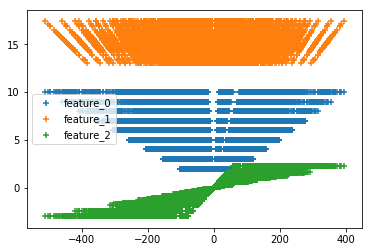

139 ms ± 796 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
# Demonstration of _add_noise

test = Pseudodata(conserve_memory=True)

test.add_feature('poisson(5)', size=50)
test.add_feature(distribution='normal(loc=15, size=50)')
test.add_feature(size=50)
%timeit test.generate_dataframe()
test.generate_dataframe()
test.get_dataframe_scatterplot()

for feature in test.data_profile:
    test.data_profile[feature]['noise_fraction'] = 0.1
%timeit test.generate_dataframe()
test.generate_dataframe()



### General usage

In [6]:
pseudodata = Pseudodata(conserve_memory=True)


In [7]:
pseudodata.list_available_distributions(detailed_list=True)[0:5]


['beta(a, b, size=None)',
 'binomial(n, p, size=None)',
 'chisquare(df, size=None)',
 'exponential(scale=1.0, size=None)',
 'f(dfnum, dfden, size=None)']

In [8]:
pseudodata.add_feature()
pseudodata.add_feature(size=100)
pseudodata.add_feature(size=5, distribution='poisson')
pseudodata.add_feature(distribution='normal(loc=5, size=100)')

my_generator = (number / 37.0 for number in range(38))
def my_function():
    global my_generator
    try:
        return next(my_generator)
    except:
        my_generator = (number / 37.0 for number in range(38))
        return next(my_generator)
pseudodata.add_feature(distribution='my_function', size=50)

pseudodata.get_profile()


,distribution,feature_name,noise_fraction,size
0,normal,0,0,10
1,normal,1,0,100
2,poisson,2,0,5
3,"normal(loc=5, size=100)",3,0,100
4,my_function,4,0,50


In [9]:
pseudodata.generate_dataframe(verbose=True)
dataframe = pseudodata.get_dataframe()
print("{0:,} rows, {1} columns.".format(*dataframe.shape))
dataframe.head()


Making DataFrame
Generating DataFrame for 25,000,000 points.
Setting up data grid. Reshaping data grid. Calculating products. Creating sorted DataFrame. Done. 
Adding feature noise.
Generation complete. The DataFrame can be reviewed with Pseudodata.get_dataframe().
25,000,000 rows, 5 columns.


,feature_0,feature_1,feature_2,feature_3,feature_4
index,,,,,
-32.106213,-1.569726,3.105246,1.0,6.586718,1.0
-32.106213,-1.569726,3.105246,1.0,6.586718,1.0
-32.106213,-1.569726,3.105246,1.0,6.586718,1.0
-32.106213,-1.569726,3.105246,1.0,6.586718,1.0
-31.679644,-1.569726,3.105246,1.0,6.499206,1.0


[]

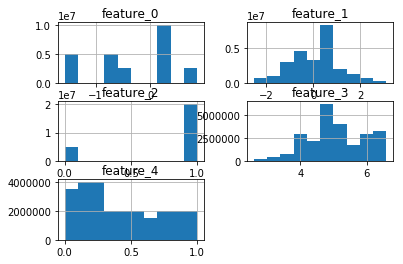

In [10]:
dataframe.hist()
plt.plot()


In [11]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 25000000 entries, -32.1062126159668 to 26.11118507385254
Data columns (total 5 columns):
feature_0    float32
feature_1    float32
feature_2    float32
feature_3    float32
feature_4    float32
dtypes: float32(5)
memory usage: 667.6 MB


### Comparing memory savings


In [13]:
regular_instance = Pseudodata()

for _ in range(4):
    regular_instance.add_feature(size=50)

%timeit regular_instance.generate_dataframe()
regular_instance.generate_dataframe(return_dataframe=True).info()


5.64 s ± 1.11 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 6250000 entries, -47.36377555179821 to 51.34064792837463
Data columns (total 4 columns):
feature_0    float64
feature_1    float64
feature_2    float64
feature_3    float64
dtypes: float64(4)
memory usage: 238.4 MB


In [14]:
reduced_instance = Pseudodata(conserve_memory=True)

for _ in range(4):
    reduced_instance.add_feature(size=50)

%timeit reduced_instance.generate_dataframe()
reduced_instance.generate_dataframe(return_dataframe=True).info()


3.53 s ± 484 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 6250000 entries, -58.57950973510742 to 61.273406982421875
Data columns (total 4 columns):
feature_0    float32
feature_1    float32
feature_2    float32
feature_3    float32
dtypes: float32(4)
memory usage: 143.1 MB


# Experimental Features

### Formatting function strings
Make `test` wrapper to contain `try`/`except` block.

In [ ]:
# def test(function):
#     def wrapper(*args):
#         function(*args)
#     return wrapper

def test(function):
    def wrapper(*args):
        try:
            print("Function result:", function(*args))
            return True
        except:
            return False
    return wrapper

@test
def iscallable(string):
    """Tests if the string represents a callable function."""
    return callable(eval(string))

@test
def iseval(string):
    """Tests if the string represents an evaluatable object."""
    return eval(string)

# print(iseval(1))
# print(iseval("1"))
# print(eval("1"))

print(iscallable("1"))
print(callable(eval(1)))


### Method chaining

Example

>`Pseudodata().add_array(100).add_array('binomial(10,0.5)').generate_dataframe()`

In [ ]:
class Test:
    value = list()
    def __init__(self):
        self.value = [1]
    
    def add_one(self, inplace=False):
        self.value.append(self.value[-1] + 1)
        return self
    
    def print_value(self):
        print(self.value)
        
b = Test()
b.add_one().add_one().add_one().add_one()
print("b.print_value():", b.print_value())



# Deprecated working methods

In [ ]:
# # OBSOLECENSE TIMELINE UNKNOWN
# def make_dataframe(array_1=None, array_2=None):
#     """Create a DataFrame from the elementwise product of two iterables."""
    
#     if array_1 is None or array_2 is None:
#         return None
    
#     if array_1.shape[0] < array_2.shape[0]:
#         index_array = array_1
#         column_array = array_2
#     else:
#         index_array = array_2
#         column_array = array_1

#     result_dataframe = pd.DataFrame(index=index_array, columns=column_array)
#     for row in result_dataframe.iterrows():
#         result_dataframe.loc[row[0]] = row[0] * result_dataframe.columns
#     return result_dataframe


# # PHASED OUT 4-July-2018
# # MADE OBSOLETE BY make_Nd_dataframe
# def _make_dataframe(self, array_1=None, array_2=None):
#     """Create a DataFrame from the elementwise product of two iterables."""

#     result_dataframe = pd.DataFrame(index=array_1, columns=array_2)

#     # Iterative operations are generally faster if row length is greater than the number of columns.
#     if result_dataframe.shape[0] < result_dataframe.shape[1]:
#         result_dataframe = result_dataframe.T

#     result_dataframe = result_dataframe.apply(lambda series: series.index) * result_dataframe.columns

#     return result_dataframe

# # PHASED OUT 4-July-2018
# # PAIRED WITH _make_dataframe
# # MADE OBSOLETE BY make_Nd_dataframe
# def _invert_dataframe(self, input_dataframe=None):
#     """Inverts a DataFrame, where the values become the index and the column and row indicies become values."""
#     if input_dataframe is None:
#         return None
#     reshaped_dataframe = input_dataframe.stack().reset_index().set_index(0)
#     feature_count = reshaped_dataframe.shape[1]
#     feature_names = list(range(feature_count))
#     reshaped_dataframe.columns = feature_names
#     return reshaped_dataframe.sort_index()


# # PHASED OUT 20-July-2018
# # MADE OBSOLETE BY: SEE COMMENT
# def _make_Nd_dataframe(self, arrays):
#     """Handles N-dimensions."""
#     grid = numpy.meshgrid(*arrays)
#     transposed_grid = numpy.transpose(grid)
#     reshaped_grid = numpy.dstack(transposed_grid).reshape(-1, len(arrays))  #Replacing dstack with ravel significantly reduces reshape time.
#     dataframe = pandas.DataFrame(reshaped_grid)
#     products = dataframe.product(axis=1)
#     dataframe.index = products
#     dataframe.columns = ["feature_{0}".format(column) for column in dataframe.columns]
#     dataframe = dataframe.sort_index()
#     return dataframe


# # PHASED OUT 25-July-2018
# # MADE OBSOLETE BY: various improvements using Numpy.
# def _make_Nd_dataframe(self, arrays):
#     """Handles N-dimensions."""
#     grid = numpy.meshgrid(*arrays)
#     transposed_grid = numpy.transpose(grid)
#     reshaped_grid = transposed_grid.ravel().reshape(-1, len(arrays))
#     dataframe = pandas.DataFrame(reshaped_grid) 
#     products = dataframe.product(axis=1)
#     dataframe.index = products
#     dataframe.columns = ["feature_{0}".format(column) for column in dataframe.columns]
#     dataframe = dataframe.sort_index()
#     return dataframe